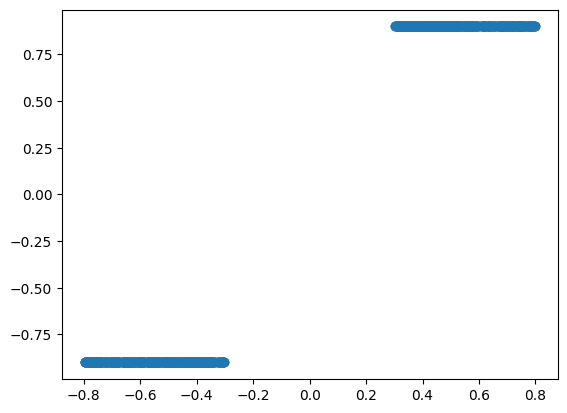

In [59]:
import stanza.runtime
stanza.runtime.setup() # setup logging, etc.

import jax
import jax.flatten_util
import matplotlib.pyplot as plt
import jax.numpy as jnp

from stanza.data import PyTreeData
from stanza.diffusion import DDPMSchedule

# Generate some data
data = "spaces"
if data == "cosine":
    def generate(rng_key: jax.Array) -> jax.Array:
        t = jax.random.uniform(rng_key, (), minval=-1, maxval=1)
        x = jnp.cos(10*t)
        return t, x
elif data == "spaces":
    space = 0.3
    diff = 0.9
    def generate(rng_key: jax.Array) -> jax.Array:
        t = jax.random.uniform(rng_key, (), minval=-1, maxval=1)
        t = (0.8-space)*t + space*jnp.sign(t)
        x = diff * jnp.sign(t)
        return t, x

train_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(42), 1024))
train_data = PyTreeData(train_data)
test_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(43), 1024))
test_data = PyTreeData(test_data)

schedule = DDPMSchedule.make_squaredcos_cap_v2(100)

plt.scatter(train_data.tree[0], train_data.tree[1])
plt.show()

In [60]:
# # The schedule also has the compute_denoised method
# # which given a (small) dataset will compute the ground-truth model output!
# # This is useful for debugging whether the denoiser has sufficient
# # capacity to capture the true score function.
# def gt_denoiser(cond, _rng_key, x, t):
#     denoised = schedule.compute_denoised(x, t, train_data.tree)
#     return schedule.output_from_denoised(x, t, denoised)

# def sample_gt(rng_key):
#     return schedule.sample(rng_key, gt_denoiser, train_data[0])

# gt_samples = jax.vmap(sample_gt)(jax.random.split(jax.random.PRNGKey(42), 1024))
# plt.clf()
# plt.scatter(gt_samples[:,0], gt_samples[:,1])
# plt.show()

In [61]:
import flax.linen as nn
from stanza.nn.embed import SinusoidalPosEmbed
from typing import Sequence

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    time_embed_dim: int

    @nn.compact
    def __call__(self, cond, x, t):
        x_flat, x_uf = jax.flatten_util.ravel_pytree(x)
        cond_flat, _ = jax.flatten_util.ravel_pytree(cond)
        x = x_flat
        embed = SinusoidalPosEmbed(self.time_embed_dim)(t)
        embed = nn.Dense(self.time_embed_dim)(embed)
        for f in self.features:
            x = jnp.concatenate([x, cond_flat], axis=-1)
            x = nn.Dense(f)(x)
            shift_scale = nn.Dense(2*f)(embed)
            shift, scale = jnp.split(shift_scale, 2, axis=-1)
            x = x*(1 + scale) + shift
            x = nn.gelu(x)
        x = nn.Dense(x_flat.shape[0])(x)
        return x_uf(x)

model = DiffusionMLP([64, 64, 64], 128)
vars = model.init(jax.random.PRNGKey(42), train_data[0][0], train_data[1][0], 0.)

In [63]:
import optax
import stanza.train as st
from stanza import partial

def loss(vars, iterations, rng_key, sample):
    # since t is [1, T] we shift it to [0, T-1]
    s, x = sample
    denoiser = lambda rng_key, x, t: model.apply(vars, s, x, t - 1)
    t_rng, l_rng = jax.random.split(rng_key)
    loss = schedule.loss(l_rng, denoiser, x)
    return st.LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )

import logging
logger = logging.getLogger("fit")
logger.setLevel(logging.DEBUG)

def fit(weight_decay=1e-2, batch_size=256, iterations=10000, cond_noise=0):
    logger.info(f"Fitting {weight_decay}")
    return st.fit(
        batch_loss_fn=st.batch_loss(partial(loss, cond_noise=cond_noise)),
        data=train_data,
        optimizer=optax.adamw(optax.cosine_decay_schedule(4e-3, iterations),
                              weight_decay=weight_decay),
        rng_key=jax.random.PRNGKey(42),
        max_iterations=iterations,
        init_vars=vars,
        batch_size=batch_size,
        hooks=[st.every_n_iterations(200, 
            st.console_logger(prefix="train.", metrics=True)
        )]
    )

In [64]:
decays = [1, 5e-1, 1e-1, 1e-2, 1e-3, 1e-4]
decay_params = {
    decay: fit(weight_decay=decay, iterations=5000) for decay in decays
}

In [74]:
def sample(params, rng_key):
    s_rng, x_rng = jax.random.split(rng_key)
    # s = jax.random.choice(s_rng, train_data.tree[0], ())
    s = jax.random.uniform(s_rng, (),
        minval=jnp.min(train_data.tree[0]),
        maxval=jnp.max(train_data.tree[0]))
    x_structure = train_data.tree[1][0]
    trained_model = lambda rng_key, x, t: model.apply(params, s, x, t - 1)
    x = schedule.sample(rng_key, trained_model, x_structure, trajectory=False)
    return (s, x)
sample = jax.vmap(sample, in_axes=(None, 0))
decay_samples = {
    decay: sample(params, jax.random.split(jax.random.PRNGKey(42), 1024))
    for decay, params in decay_params.items()
}
import plotly.graph_objects as go
from scipy import odr
fig = go.Figure()
for decay, samples in decay_samples.items():
    data = odr.Data(samples[0], samples[1])
    output = odr.ODR(data, odr.polynomial(10)).run()
    poly = jnp.array(output.beta[::-1])
    xs = jnp.linspace(jnp.min(samples[0]), jnp.max(samples[0]), 100)
    vals = jnp.polyval(poly, xs)
    fig.add_trace(go.Scatter(x=xs, y=vals, mode="lines", name=f"decay={decay}"))
    # fig.add_trace(go.Scatter(x=samples[0], y=samples[1], mode="markers", name=f"decay={decay}", opacity=0.5))
fig

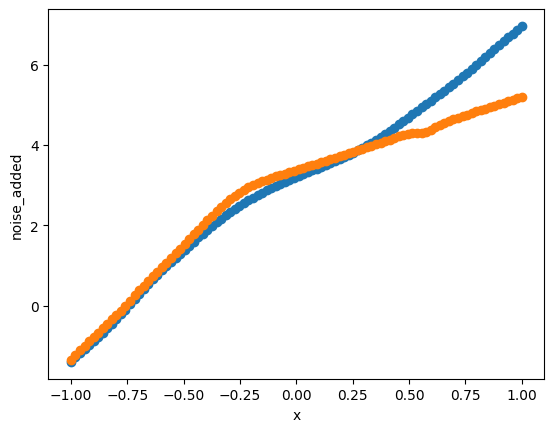

In [56]:
x = jnp.linspace(-1, 1, 100)
s = -0.3
t = 10

@jax.jit
def model_denoised(params, x):
    mo = model.apply(params, s, x, t - 1)
    # x_denoised = schedule.denoised_from_output(x, t, model.apply(params, s, x, t - 1))
    return mo
model_denoised = jax.vmap(model_denoised, in_axes=(None, 0))
high_denoised = model_denoised(high_decay, x)
low_denoised = model_denoised(low_decay, x)
plt.clf()
plt.scatter(x, high_denoised)
plt.scatter(x, low_denoised)
plt.ylabel("noise_added")
plt.xlabel("x")
# plt.ylim([-1, 1])
plt.show()